In [1]:
import numpy as np
import pandas as pd

In [2]:
# split to hour, minute, second

def add_time_string(df):
    df = df.reset_index(drop=True)
    df["queryts_new"] = pd.DataFrame(pd.to_datetime(df.queryts, unit='s'))
    df.queryts_new = df.queryts_new.astype(str)

    con = pd.DataFrame(df.queryts_new.str.split(" ",2).tolist(), columns = ['a','b'])
    con1 = pd.DataFrame(con.b.str.split(":",3).tolist(), columns = ['hr','mins','sec'])
    df["hr"] = con1.hr
    df.hr = pd.to_numeric(df.hr, errors = 'coerce')
    df["min"] = con1.mins
    df.min = pd.to_numeric(df.min, errors = 'coerce')

    print (df.shape)
    return df

In [3]:
# each file min count in each day
# all file count in each hour
# each file count in each hour
# each file count in each min

def groupby_date_file(path):
    df = pd.read_pickle(path)
    df['custXprod_id'] = df.customer_id + df.product_id
    df = add_time_string(df)

    f = {'date_new': ['min', 'count']}
    g0 = df.groupby(["file_id"]).aggregate(f).reset_index()
    g0.columns = ["file_id", "file_id_first_date", "file_id_count"]
    g0 = pd.merge(g0, df_train_set, how="left", on="file_id")

    f = {'file_id': ['count']}
    g1 = df.groupby(["date_new", "hr"]).aggregate(f).reset_index()
    g1.columns = ["date_new", "hr", "date_new_hr_count"]

    f = {'custXprod_id': ['count']}
    g2 = df.groupby(["file_id","date_new","hr","min"]).aggregate(f).reset_index()
    g2.columns = ["file_id","date_new","hr","min","custXprod_min_count"]

    f = {'custXprod_id': ['count']}
    g3 = df.groupby(["file_id","date_new","hr"]).aggregate(f).reset_index()
    g3.columns = ["file_id","date_new","hr","custXprod_hr_count"]

    print (g0.shape, g1.shape, g2.shape, g3.shape)
    return g0, g1, g2, g3

In [4]:
df_train_set = pd.read_csv("dataset/training-set.csv")
df_test_set = pd.read_csv("dataset/testing-set.csv")
df = pd.concat([df_train_set, df_test_set], axis=0)

print (df.shape)

(81977, 2)


In [5]:
path = ["train1","train2","train3","test_1","test_2","test_3","valid"]

g0, g1, g2, g3 = groupby_date_file("dataset/" + path[0] + ".pkl")
for _ in path[1:]:
    g0_, g1_, g2_, g3_ = groupby_date_file("dataset/" + str(_) + ".pkl")
    g0 = pd.concat([g0, g0_], axis=0)
    g1 = pd.concat([g1, g1_], axis=0)
    g2 = pd.concat([g2, g2_], axis=0)
    g3 = pd.concat([g3, g3_], axis=0)

print (g0.shape, g1.shape)

(6898481, 11)
(13527, 4) (336, 3) (4155801, 5) (588664, 4)
(17966156, 11)
(15832, 4) (336, 3) (9836881, 5) (860189, 4)
(21775315, 11)
(22558, 4) (528, 3) (12852325, 5) (1260654, 4)
(3948342, 11)
(9515, 4) (336, 3) (2369382, 5) (302114, 4)
(21475256, 11)
(19986, 4) (336, 3) (13947232, 5) (1364522, 4)
(3599267, 11)
(8588, 4) (192, 3) (2401866, 5) (356674, 4)
(7610293, 11)
(10741, 4) (384, 3) (4651747, 5) (610580, 4)
(100747, 4) (2448, 3)


In [13]:
# g2: 計算一分鐘出現很多次的比例

def f_(x):
    x = np.array(x)
    return sum(x > 2)

f = {'custXprod_min_count': ['max', 'count', lambda x: f_(x)]}
g = g2.groupby(["file_id"]).aggregate(f).reset_index()
g.columns = ["file_id", "custXprod_mins_count_max", "custXprod_mins", "custXprod_mins_count_big"]
g = pd.merge(g, df_train_set, how="left", on="file_id")
g["custXprod_mins_count_big_ratio"] = g.custXprod_mins_count_big / g.custXprod_mins

print (g.shape)

(81894, 6)


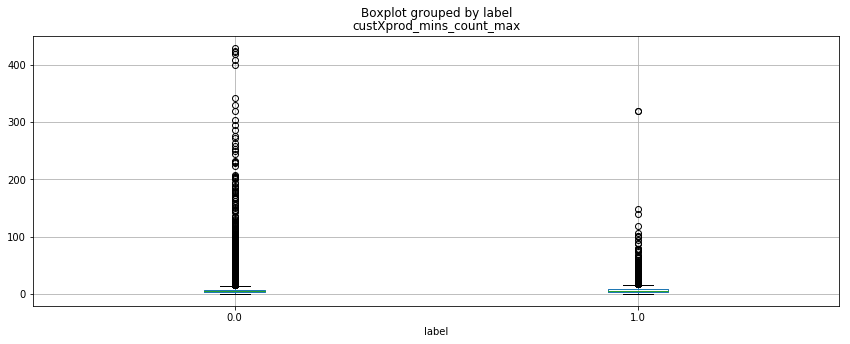

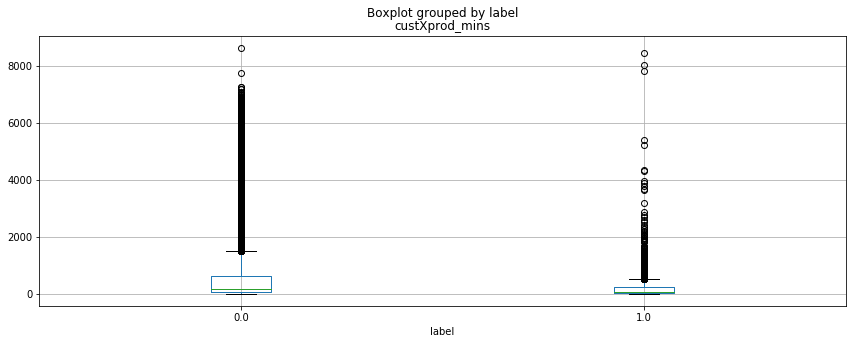

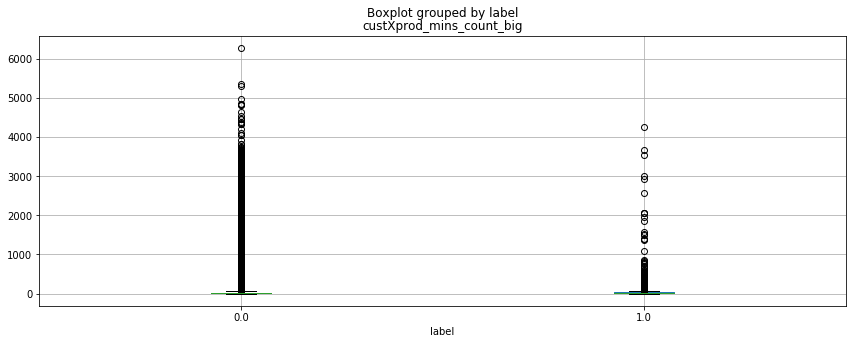

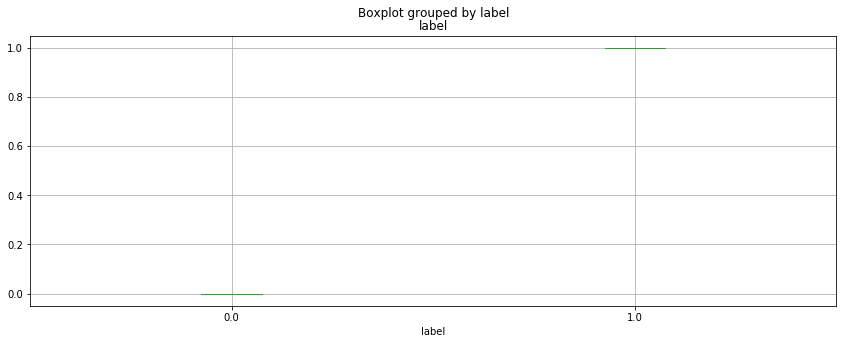

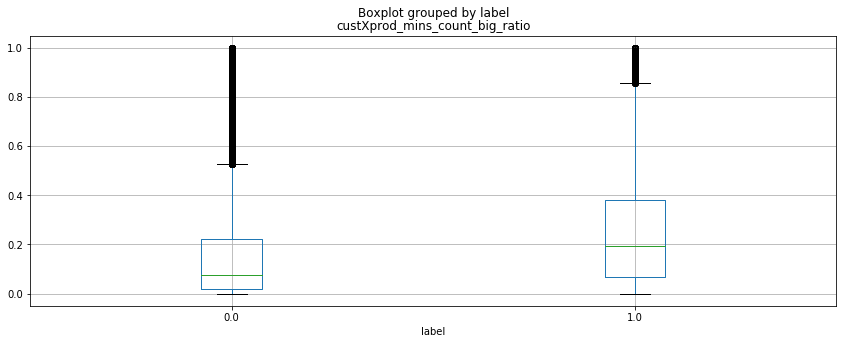

In [14]:
import pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (14.0, 5.0)

for v_ in g.columns[1:]:
    g.dropna().boxplot(v_, 'label')
    plt.show()

In [8]:
g = g[["file_id", "custXprod_mins_count_big_ratio"]]
g.to_csv("dataset/file_mins_count_big_ratio.csv", index=False)

In [23]:
g.iloc[0, :]

file_id                           00008c73ee43c15b16c26b26398c1577
custXprod_mins_count_max                                         3
custXprod_mins                                                 122
custXprod_mins_count_big                                         3
label                                                          NaN
custXprod_mins_count_big_ratio                           0.0245902
Name: 0, dtype: object

In [9]:
# g0

f = {'file_id_first_date': 'min',
     'file_id_count': 'sum',
     'label': 'max'}
g0_ = g0.groupby(['file_id']).aggregate(f).reset_index()
g0_.columns = g0.columns

f = {'label': ["count", "sum"]}

g0_1 = g0_.dropna().groupby(["file_id_first_date"]).aggregate(f).reset_index()
g0_1.columns = ["file_id_first_date", "file_id_first_date_count", "file_id_first_date_label_sum"]
g0_1["ratio"] = g0_1.file_id_first_date_label_sum / g0_1.file_id_first_date_count

print (g0_1.shape)

(62, 4)


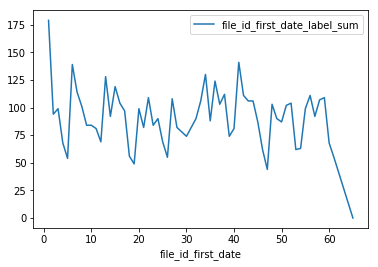

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

g0_1.plot(x='file_id_first_date', y='file_id_first_date_label_sum')
plt.show()

### Hour

In [16]:
# g1

f = {'date_new_hr_count': 'sum'}

g1_ = g1.groupby(['date_new', 'hr']).aggregate(f).reset_index()
g1_.columns = ["date_new", 'hr', "date_new_count"]
g1_["time_hr"] = (g1_.date_new - 1)*24 + g1_.hr

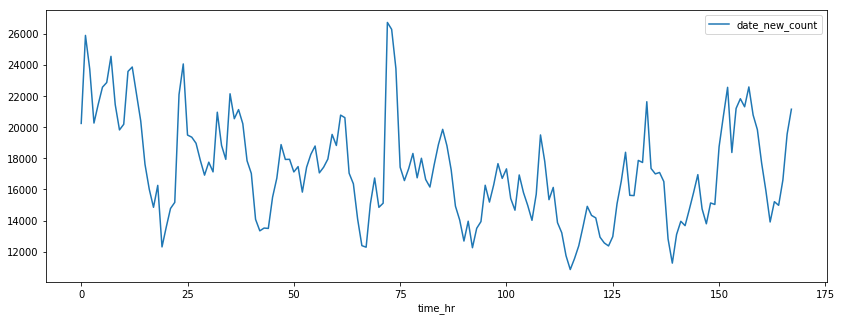

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

g1_[(g1_.date_new <= 7)].plot(x='time_hr', y='date_new_count')
plt.show()

In [18]:
g3 = pd.merge(g3, g1_[["date_new","hr","date_new_count"]], how="left", on=["date_new","hr"])

In [19]:
g3["custXprod_hr_count_ratio"] = g3.custXprod_hr_count / g3.date_new_count
g3 = pd.merge(g3, df_train_set, how="left", on="file_id")

In [20]:
def f_(x):
    mean_ = np.mean(x)
    if mean_ > 0.00038:
        label_ = 1
    else:
        label_ = 0
    return label_

f = {'custXprod_hr_count_ratio': lambda x: f_(x)}
g3_ = g3.groupby(["file_id"]).aggregate(f).reset_index()
g3_.columns = ["file_id","custXprod_hr_count_ratio_high"]
g3_ = pd.merge(g3_, df_train_set, how="left", on="file_id")

In [21]:
g3_ = g3_[["file_id","custXprod_hr_count_ratio_high"]]
g3_.to_csv("dataset/file_hr_count_ratio_high.csv", index=False)

In [26]:
g3_.iloc[20, :]

file_id                          000f15bf6a8f0b51126ece0ce93af65c
custXprod_hr_count_ratio_high                                   0
Name: 20, dtype: object